In [23]:
#%pip install tslearn

In [24]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
import numpy as np
from cluster_dtw import *
import matplotlib.pyplot as plt
from src.features.meteorological_features import MeteorologicalFeatures
from src.features.air_quality_features import AirQualityFeatures
from src.features.hopital_features import HopitalFeatures
from src.features.epidemiological_features import EpidemiologicalFeatures
from src.features.google_trend_features import GoogleTrendFeatures
from src.features.sociological_features import SociologicalFeatures
from src.features.sports_features import SportsCompetitionFeatures
from src.features.traffic_features import TrafficFeatures
from src.features.population_features import PopulationFeatures
from src.location.location import Location, ETAB_NAMES

In [25]:
def air_avg(df: pd.DataFrame):
    for name in ['NO2', 'PM10', 'PM25', 'O3']:
        # Filter columns that start with name +"_"
        name_columns = [col for col in df.columns if col.startswith(name + "_")]
        # Check if there is only one name + "_" column
        if len(name_columns) == 1:
            # If only one column, copy its values to the name + '_avg' column
            df[name + '_avg'] = df[name_columns[0]]
        elif len(name_columns) > 1:
            # If more than one column, calculate the row-wise mean
            df[name + '_avg'] = df[name_columns].mean(axis=1)
        # Drop the name + "_" columns
        df = df.drop(columns=name_columns)
    return df

In [26]:
def plot_time_series(time_series, date_range, labels, value='Value', title='etabs'):
    # Plot all three time series
    plt.figure(figsize=(12, 6))
    for i in range(len(labels)):
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)

    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel(value)
    plt.title(f'Comparison of {title} {value}')
    plt.legend()

    plt.grid(True)
    plt.show()

In [27]:
def subplots_time_series(time_series, date_range, labels, value='Value'):
    plt.figure(figsize=(10, 15))

    # Subplot for ts
    for i in range(len(labels)):
        plt.subplot(len(labels), 1, i+1)
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)
        plt.title(f"{labels[i]} {value}")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [28]:
start_date = "2019-01-01"
end_date = "2023-12-31"

DATA_DIR = '../data/features/'

#ETABS = ETAB_NAMES
ETABS = [etab[1] for etab in ETAB_NAMES]
#ETABS = ['CHU Dijon', 'HNFC', 'CH Beaune']
#ETABS = ['CH Chaumont']

EXOGENOUS = True
ENDOGENOUS = True


exogenous_features = []
endogenous_features = []

if EXOGENOUS:
    exogenous_features = [
        AirQualityFeatures(name='airquality'),
        MeteorologicalFeatures(name='meteorological'),
        EpidemiologicalFeatures(name='epidemiological'),
        GoogleTrendFeatures(name='googletrend'),
        SociologicalFeatures(name='sociological'),
        SportsCompetitionFeatures(name='sportscompetition'),
        TrafficFeatures(name='traffic'),
        PopulationFeatures(name='population')
    ]

if ENDOGENOUS:
    endogenous_features = [
        HopitalFeatures(name='hopital', include_hnfc_moving=False, include_nb_hospit=False)
    ]


features = exogenous_features + endogenous_features

date_range = pd.date_range(start=start_date, end=end_date, freq="1D")



In [29]:
datasets = []
for etab in ETABS:
    loc = Location(etab)
    data = pd.DataFrame()
    print(loc)
    for i in range(len(features)):
        #if i != 7: continue
        if type(features[i]) == AirQualityFeatures:
            data = data.merge(air_avg(features[i].fetch_data_function(location=loc, feature_dir=f'{DATA_DIR}{features[i].name}features/').loc[start_date:end_date]), left_index=True, right_index=True, how="outer")
        else:
            data = data.merge(features[i].fetch_data_function(location=loc, feature_dir=f'{DATA_DIR}{features[i].name}features/', start_date=start_date, stop_date=end_date).loc[start_date:end_date], left_index=True, right_index=True, how="outer")
    datasets.append(data)
    #data.reset_index(inplace=True)
    #print(data.size)
datasets[0]

CH Beaune is located at Beaune, 21054, Côte-d'Or, Bourgogne-Franche-Comté


CH Semur is located at Semur-en-Auxois, 21603, Côte-d'Or, Bourgogne-Franche-Comté


CH Chatillon Montbard is located at Châtillon-sur-Seine, 21154, Côte-d'Or, Bourgogne-Franche-Comté


HNFC is located at Trévenans, 90097, Territoire de Belfort, Bourgogne-Franche-Comté


CHU Besançon is located at Besançon, 25056, Doubs, Bourgogne-Franche-Comté


CH privé Dijon is located at Dijon, 21231, Côte-d'Or, Bourgogne-Franche-Comté


CHU Dijon is located at Dijon, 21231, Côte-d'Or, Bourgogne-Franche-Comté


CH Langres is located at Langres, 52269, Haute-Marne, Grand Est


CH Chaumont is located at Chaumont, 52121, Haute-Marne, Grand Est


,NO2_avg,PM10_avg,PM25_avg,O3_avg,meteo_tavg_CH Beaune,meteo_tmin_CH Beaune,meteo_tmax_CH Beaune,meteo_prcp_CH Beaune,meteo_snow_CH Beaune,meteo_wdir_CH Beaune,...,Y75T79,Y80T84,Y85T89,Y90T94,Y_GE75,Y_GE95,Y_LT20,Y_LT5,_T,Total_CH Beaune
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,13.475,14.50,6.70,36.5,5.9,4.4,7.2,0.5,0.0,319.0,...,18051,15266,11434,5800,52455,1904,121319,26662,534124,54
2019-01-02,11.225,14.75,5.70,65.5,4.6,2.6,6.6,0.0,0.0,343.0,...,18051,15266,11433,5800,52456,1904,121319,26660,534126,64
2019-01-03,13.225,17.50,7.25,57.0,1.3,-2.2,4.4,0.0,0.0,5.0,...,18052,15266,11433,5800,52458,1905,121319,26659,534129,54
2019-01-04,15.725,17.25,9.40,49.0,1.4,-1.4,5.1,0.0,0.0,359.0,...,18052,15266,11433,5801,52460,1905,121319,26657,534131,61
2019-01-05,12.225,16.50,8.90,42.0,3.2,-1.0,5.0,0.0,0.0,323.0,...,18053,15267,11433,5801,52462,1906,121319,26656,534134,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,22.725,18.25,12.50,25.5,2.1,-1.0,6.0,0.0,0.0,244.0,...,24943,15375,11118,6454,60586,2693,117352,24340,537743,55
2023-12-28,19.975,14.50,10.75,41.5,5.9,2.7,8.4,3.7,0.0,228.0,...,24949,15376,11118,6455,60593,2693,117349,24339,537744,57
2023-12-29,13.725,12.50,7.80,48.5,8.7,5.9,12.0,0.0,0.0,204.0,...,24955,15377,11118,6456,60600,2693,117346,24337,537746,68


In [30]:
ts = []
for etab in ETABS:
    ts.append(datasets[ETABS.index(etab)]['Total_' + etab])

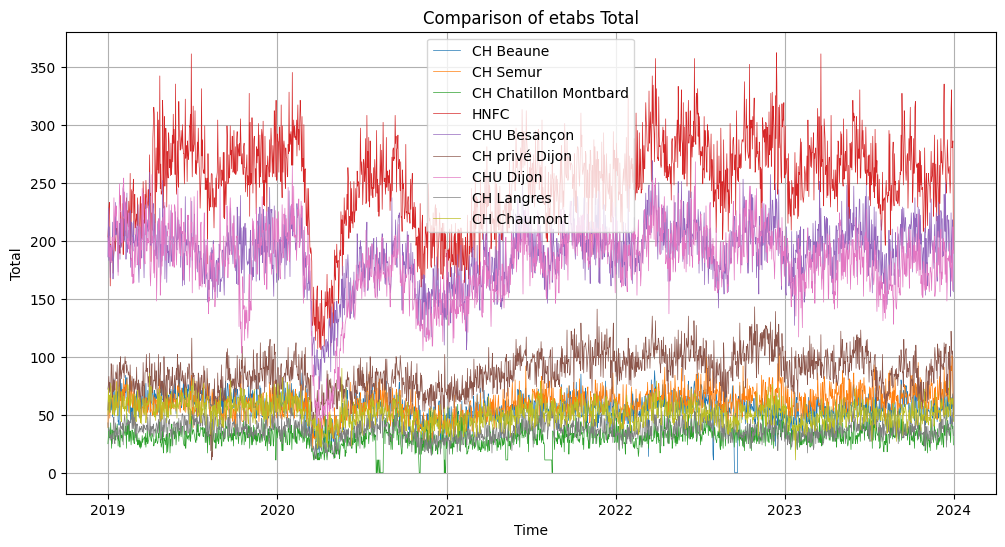

In [31]:
plot_time_series(ts, date_range, ETABS, value='Total')

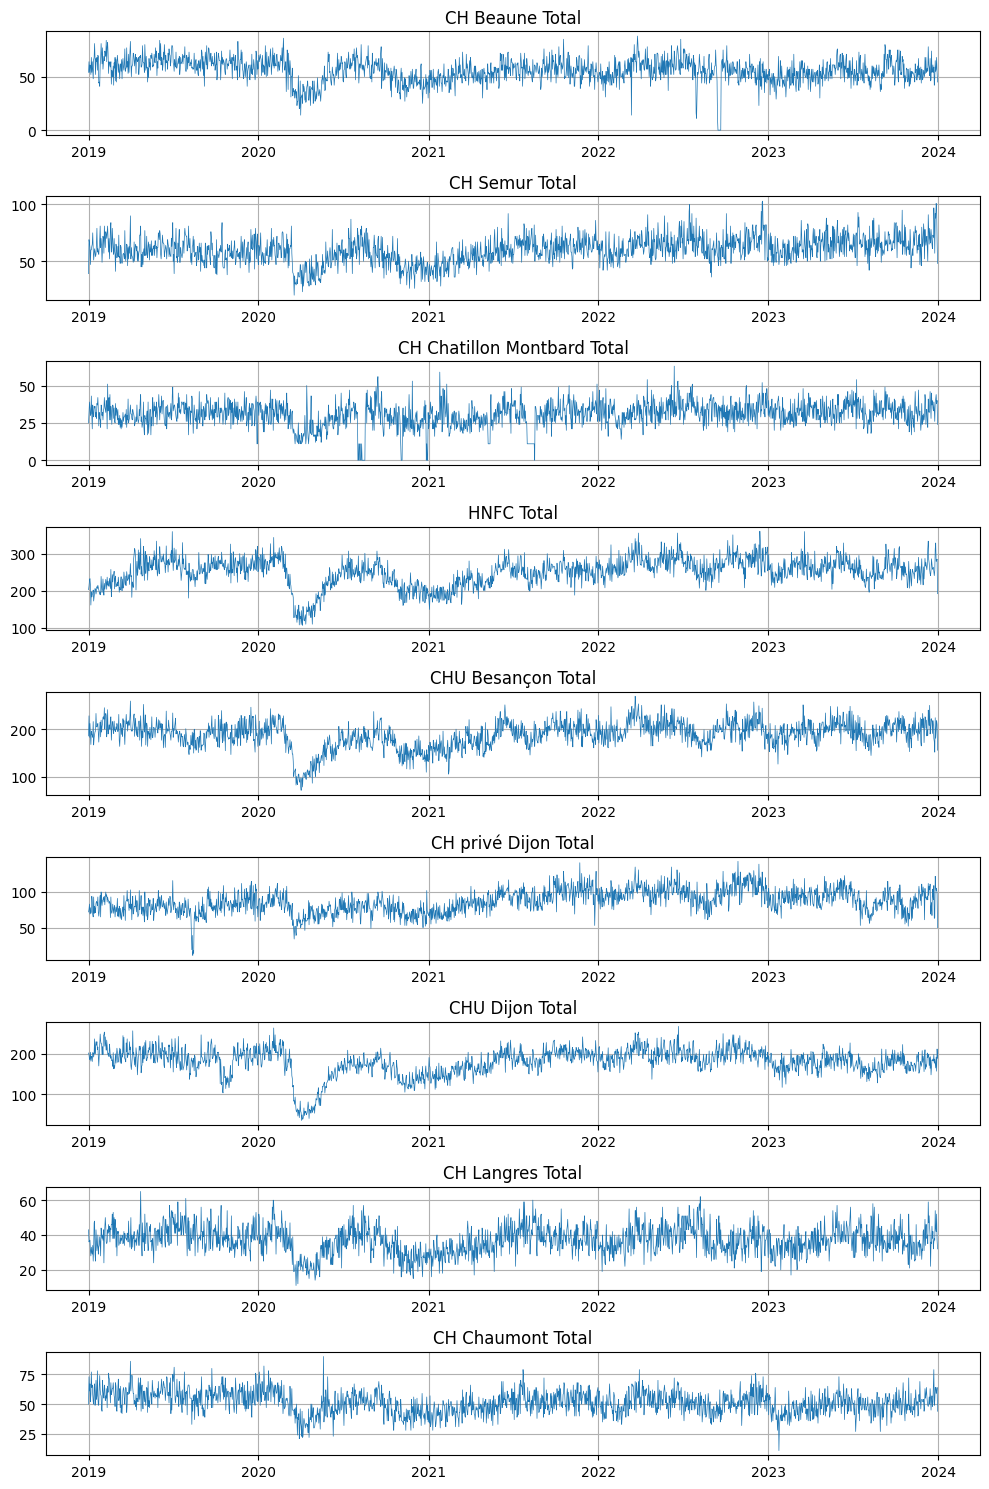

In [32]:
subplots_time_series(ts, date_range, ETABS, value='Total')

In [33]:
clusters, dtw_matrix, n_clusters = cluster_dtw(datasets, scale=True, verbose=True)
clusters_etab = output_clusters([etab for etab in ETABS], clusters)

Number of clusters: 2, Silhouette Score: 0.564
Number of clusters: 3, Silhouette Score: 0.598
Number of clusters: 4, Silhouette Score: 0.610
Number of clusters: 5, Silhouette Score: 0.508
Number of clusters: 6, Silhouette Score: 0.369
Number of clusters: 7, Silhouette Score: 0.292
Number of clusters: 8, Silhouette Score: 0.218

Optimal number of clusters: 4 -> [0 0 0 2 3 0 0 1 1]
Cluster 0
['CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon', 'CHU Dijon']
Cluster 2
['HNFC']
Cluster 3
['CHU Besançon']
Cluster 1
['CH Langres', 'CH Chaumont']


In [34]:
#plot_pca(dtw_matrix, n_clusters, ETABS)

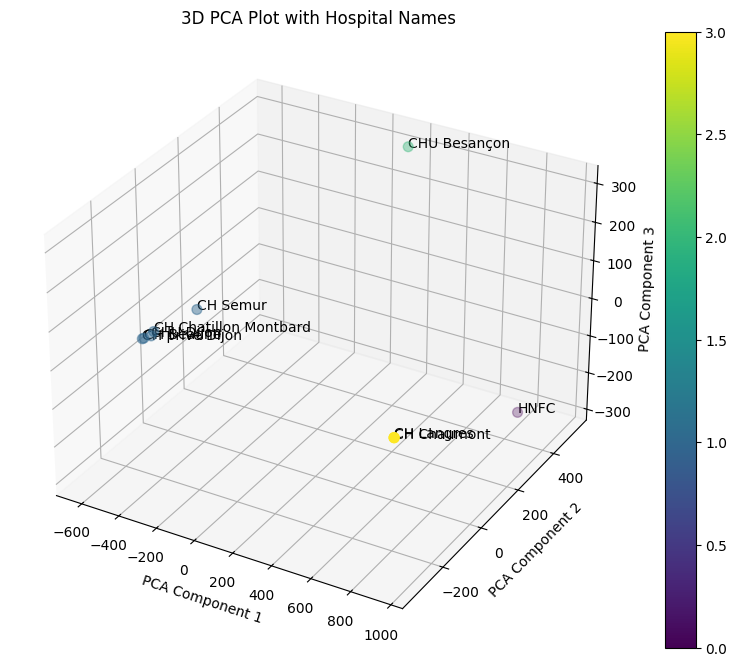

In [35]:
plot_pca_3D(dtw_matrix, n_clusters, ETABS)

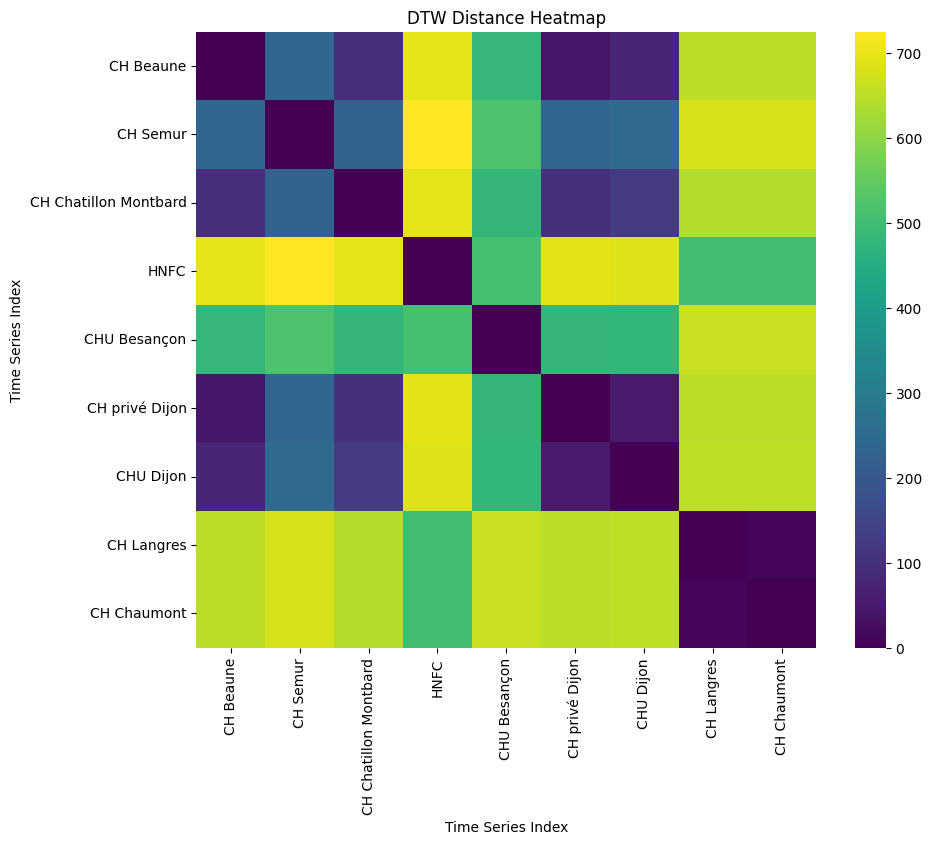

In [36]:
plot_heatmap(dtw_matrix, ETABS)

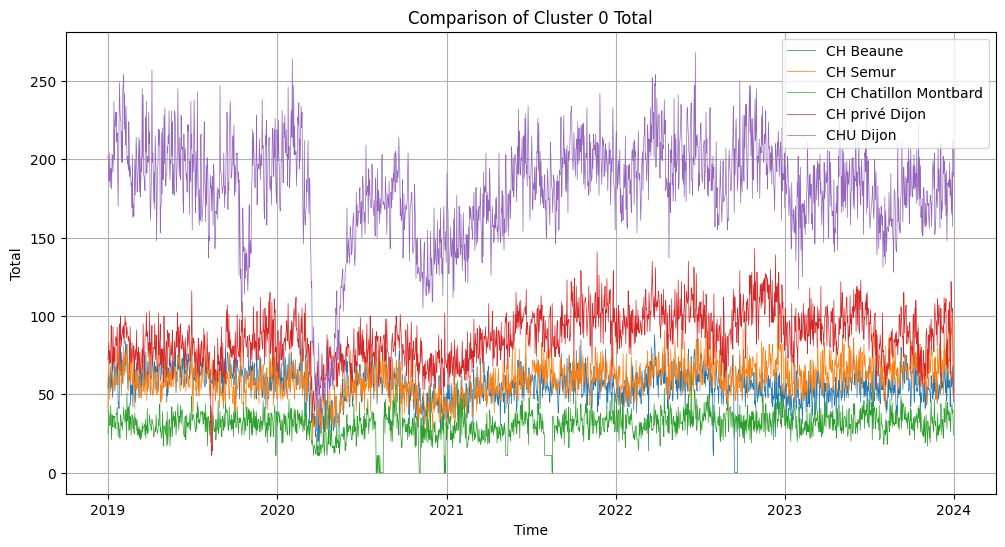

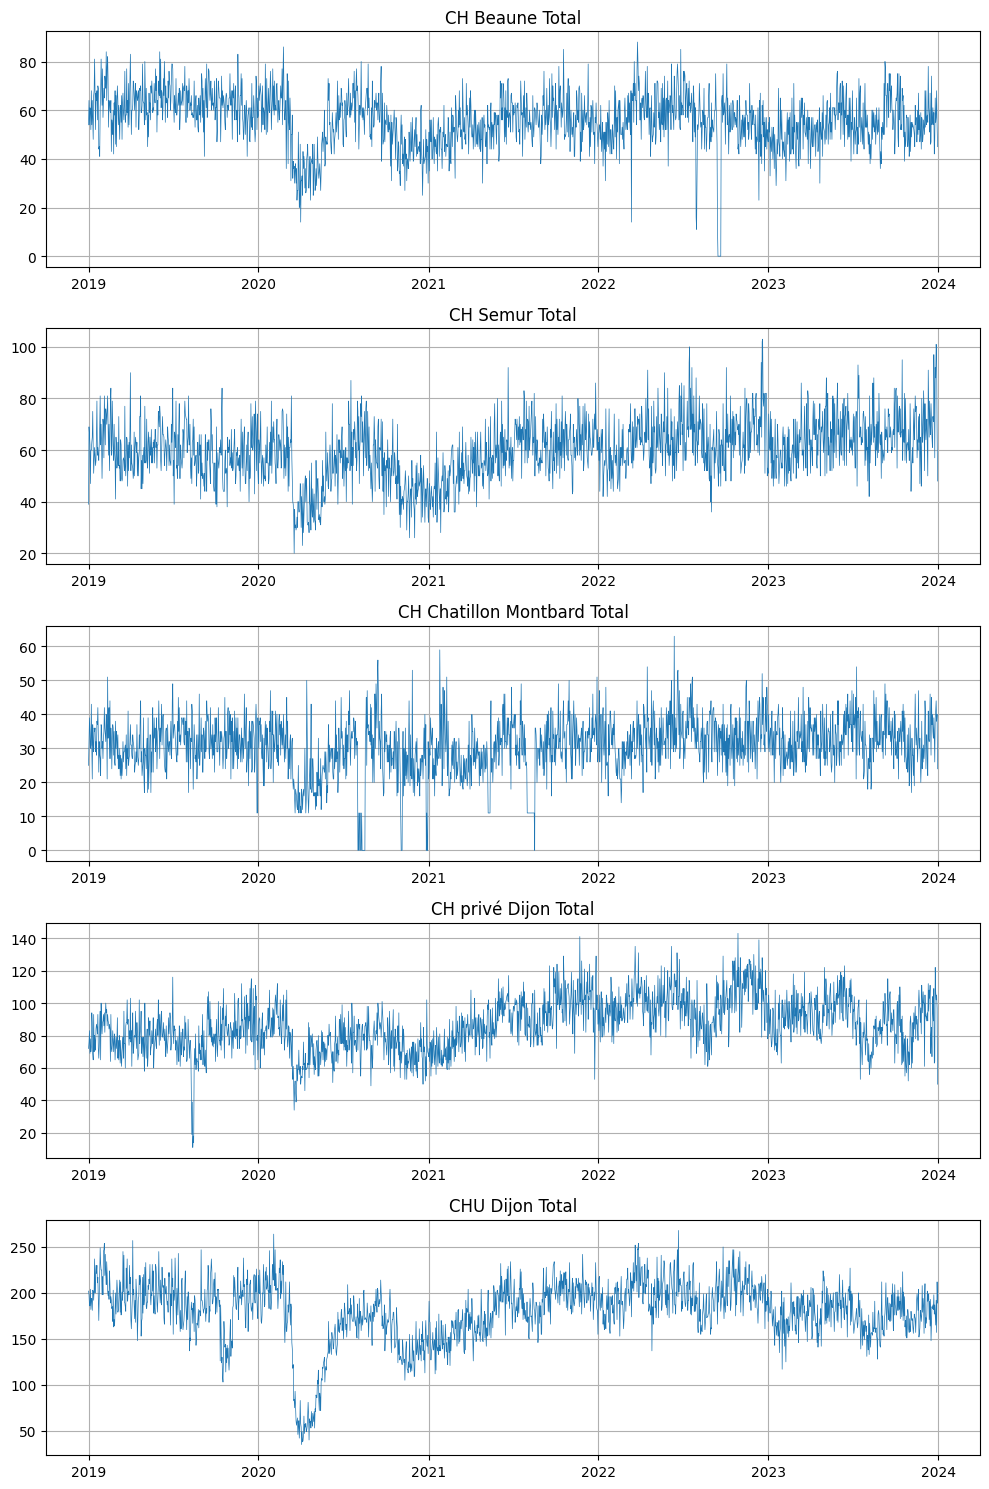

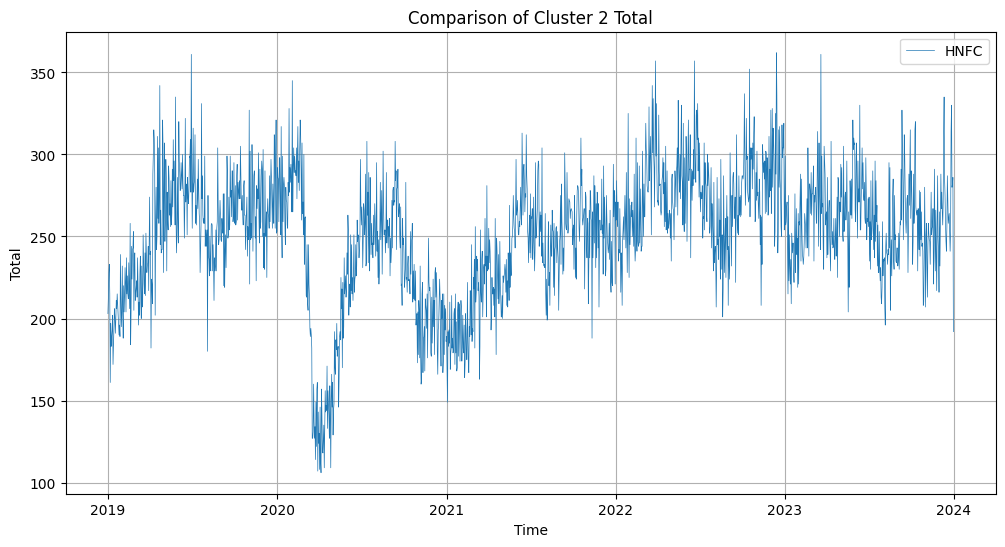

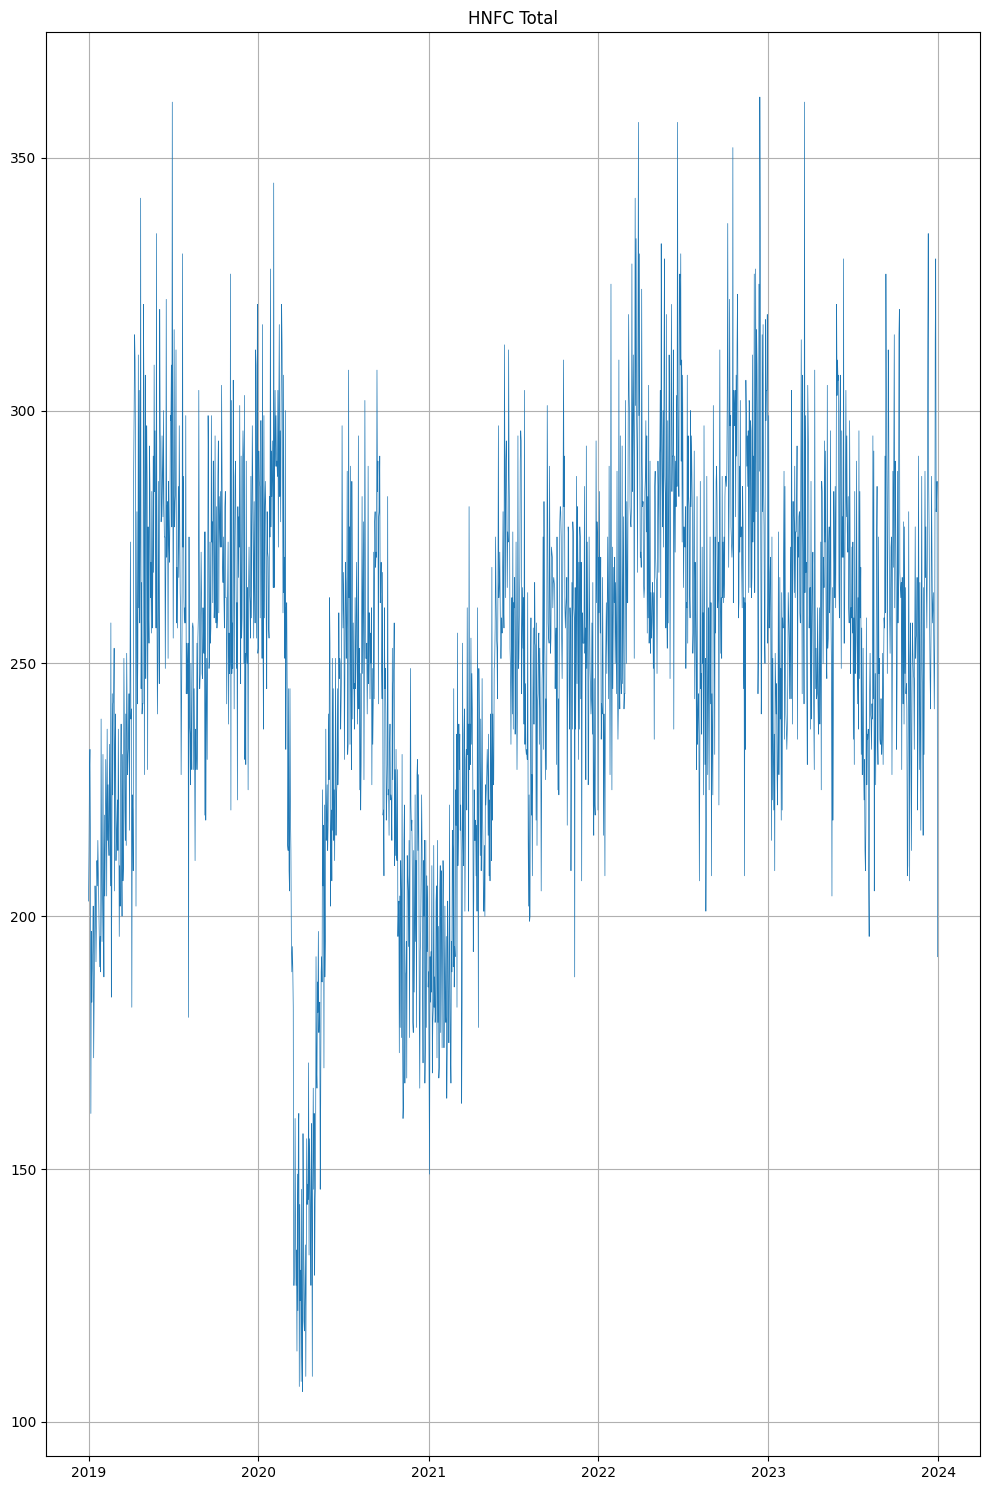

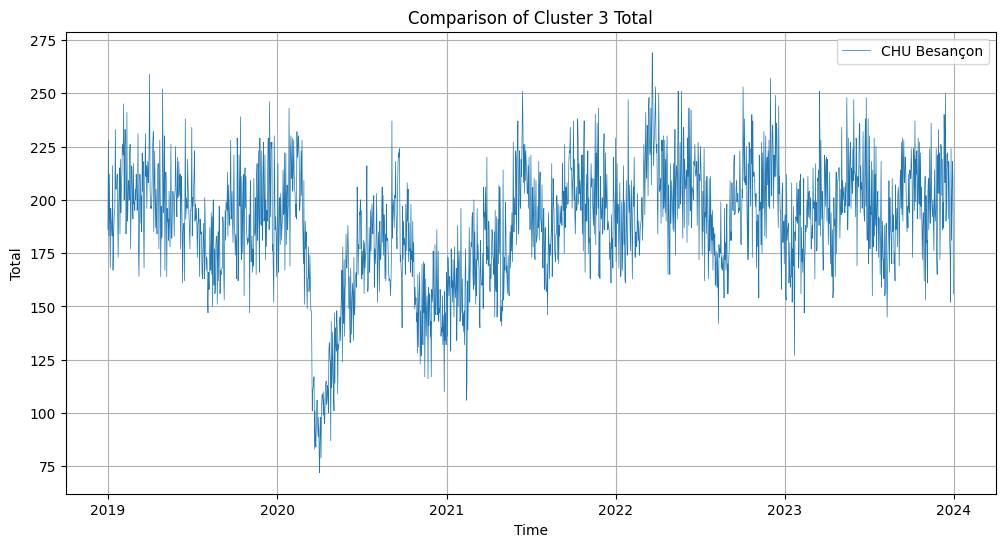

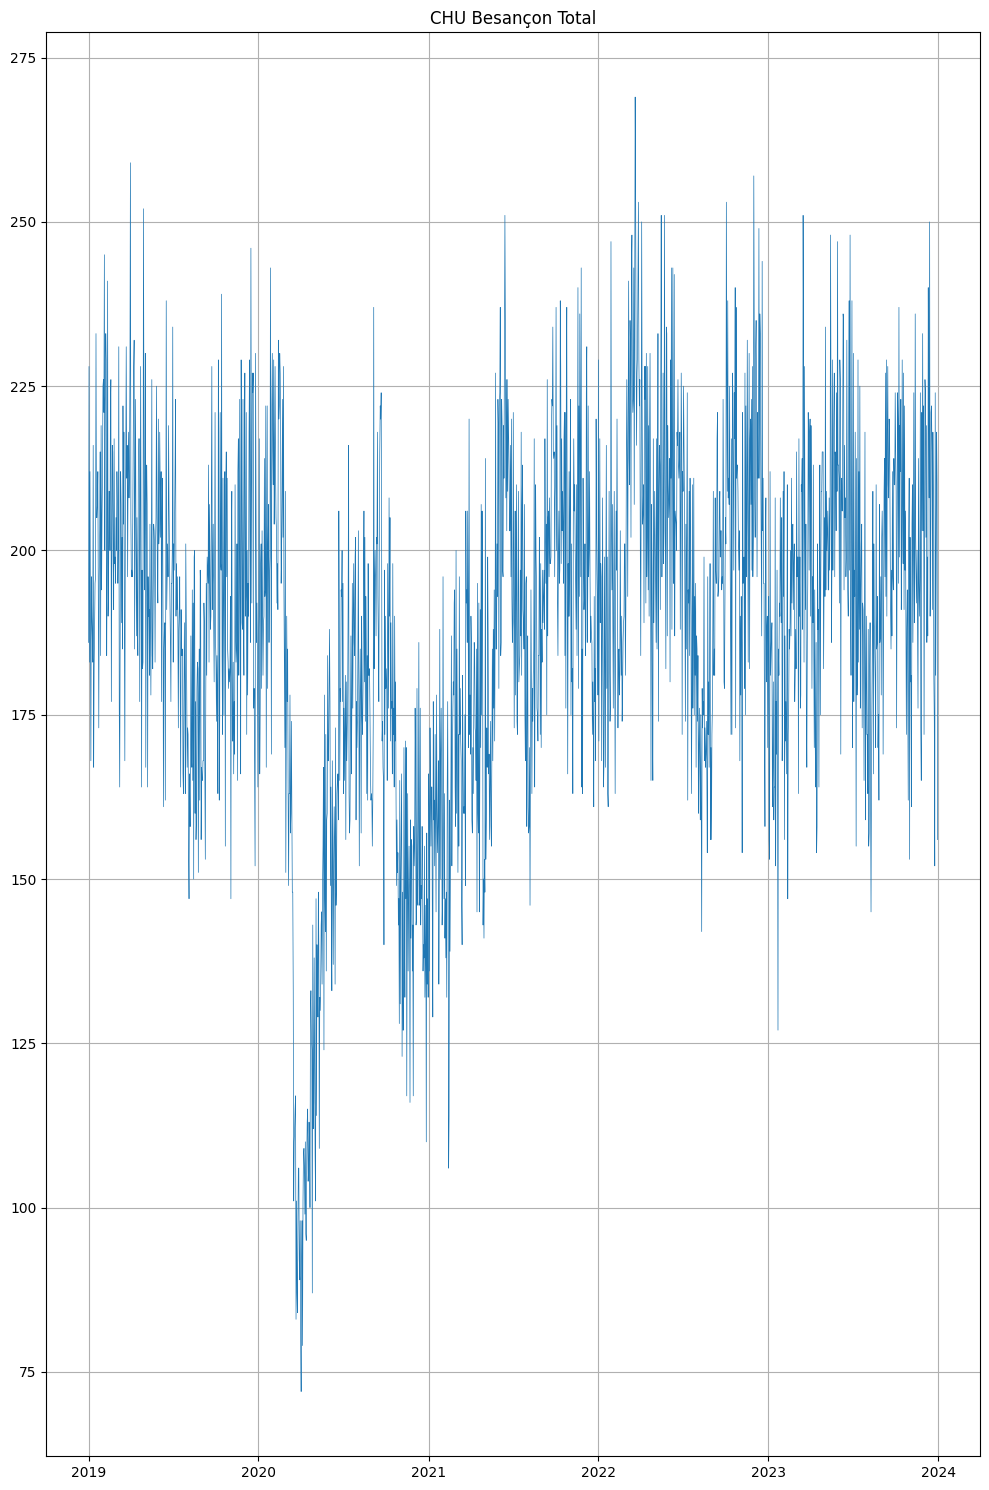

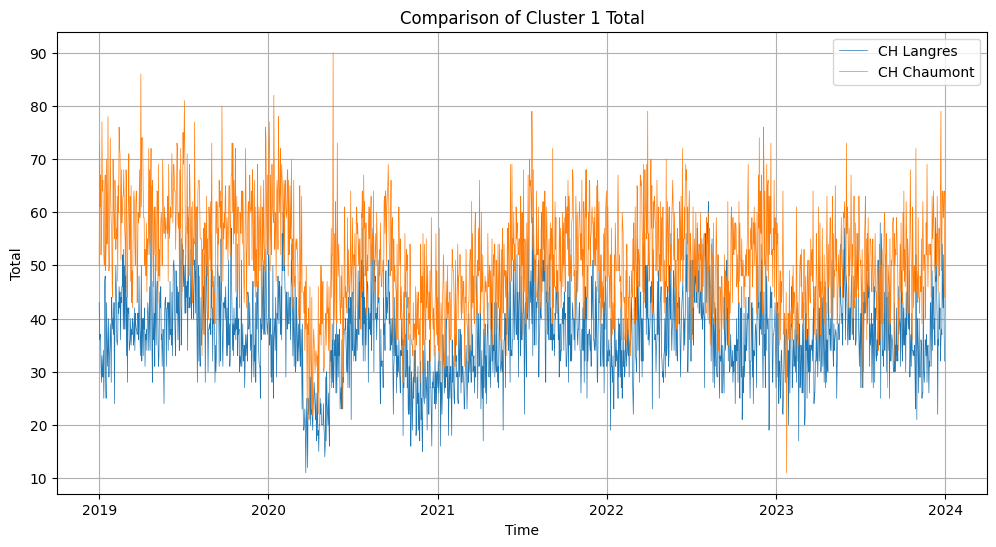

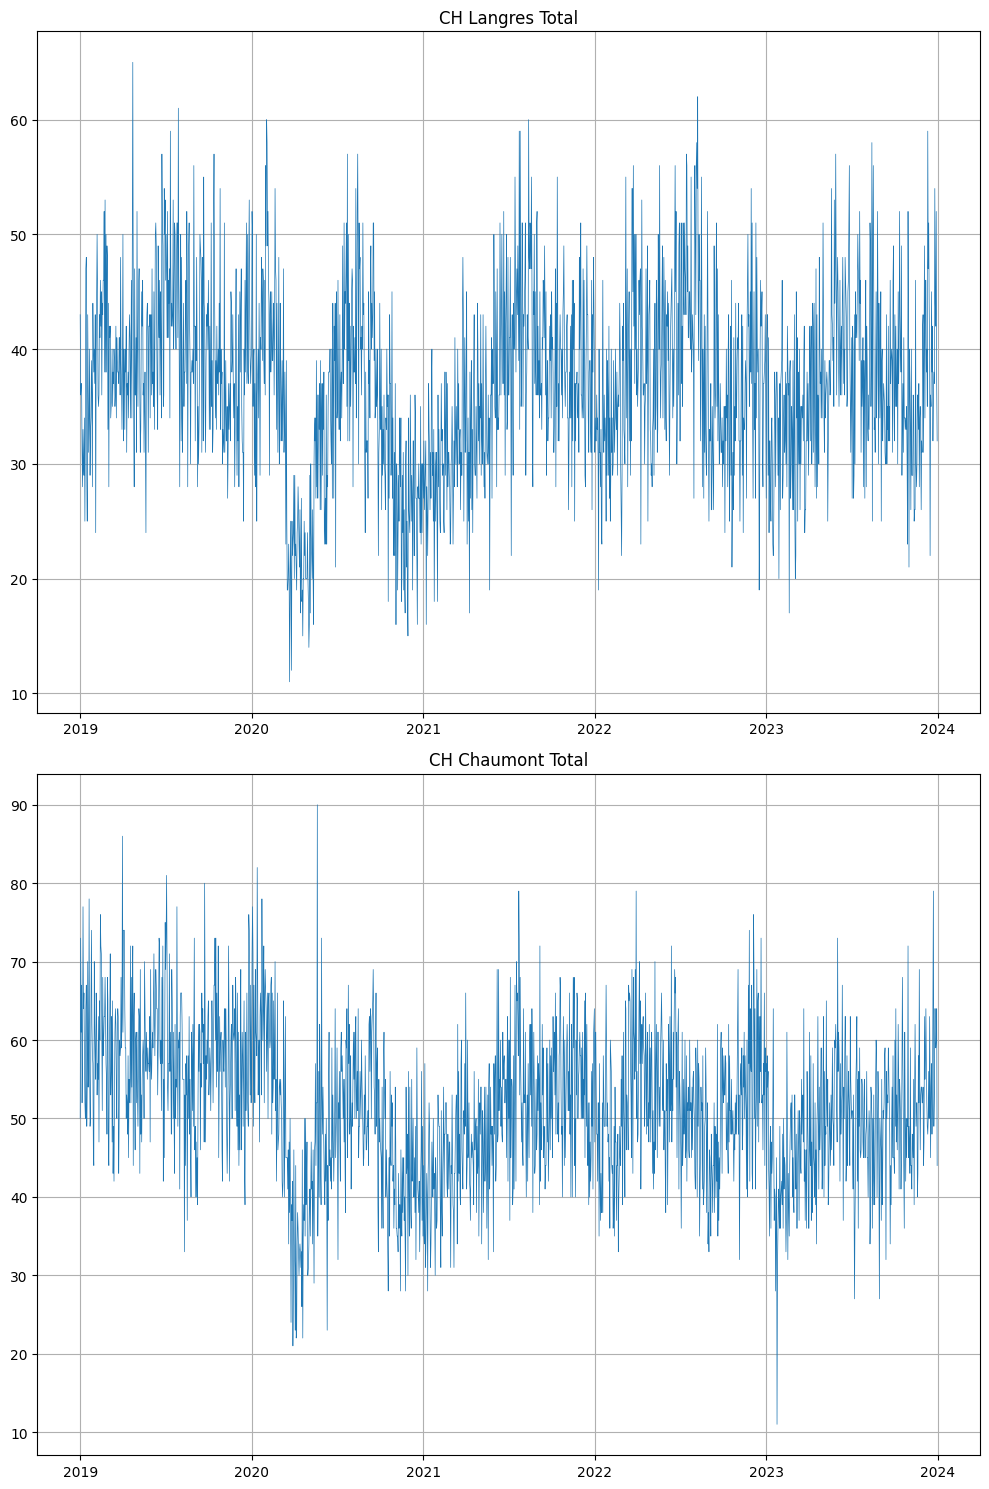

In [37]:
for cluster in clusters_etab:
    ts = []
    for etab in clusters_etab[cluster]:
        ts.append(datasets[ETABS.index(etab)]['Total_' + etab])
    plot_time_series(ts, date_range, clusters_etab[cluster], value='Total', title='Cluster ' + str(cluster))
    subplots_time_series(ts, date_range, clusters_etab[cluster], value='Total')